In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

In [ ]:
#test, train 분리
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

print('훈련용 뉴스 기사 : {}'.format(len(X_train)))
print('테스트용 뉴스 기사 : {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리 : {}'.format(num_classes))

2110848/2110848 [==============================] - 0s 0us/step
훈련용 뉴스 기사 : 8982
테스트용 뉴스 기사 : 2246
카테고리 : 46


In [ ]:
print('첫번째 훈련용 뉴스 기사 :',X_train[0])
print('첫번째 훈련용 뉴스 기사의 레이블 :',y_train[0])

첫번째 훈련용 뉴스 기사 : [1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
첫번째 훈련용 뉴스 기사의 레이블 : 3


뉴스 기사의 최대 길이 :2376
뉴스 기사의 평균 길이 :145.5398574927633


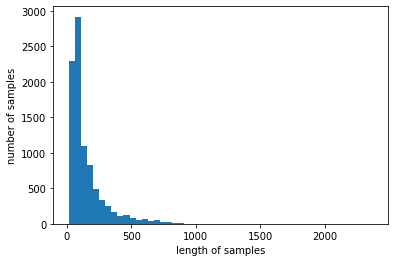

In [ ]:
#뉴스 기사의 최대/평균 길이 구하기
print('뉴스 기사의 최대 길이 :{}'.format(max(len(sample) for sample in X_train)))
print('뉴스 기사의 평균 길이 :{}'.format(sum(map(len, X_train))/len(X_train)))

plt.hist([len(sample) for sample in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
#X_train에 들어있는 숫자들이 각자 어떤 단어들을 나타내고 있는지 확인
#reuters.get_word_index는 각 단어와 그 단어에 부여된 인덱스를 리턴
word_to_index = reuters.get_word_index()
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[4])) 

550378/550378 [==============================] - 0s 0us/step
빈도수 상위 1번 단어 : the


In [ ]:
#index_to_word에서 숫자 0은 패딩을 의미하는 토큰인 pad, 숫자 1은 문장의 시작을 의미하는 sos, 숫자 2는 OOV를 위한 토큰인 unk라는 특별 토큰에 맵핑
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index] = token

print(' '.join([index_to_word[index] for index in X_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


### 로이터 뉴스 분류하기

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

vocab_size = 1000
max_len = 100

(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
embedding_dim = 128
hidden_units = 128
num_classes = 46

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

#검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크에 도달하지 못하여도 학습을 조기 종료(Early Stopping)합니다.
#ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.
#validation_data로는 X_test와 y_test를 사용합니다. val_loss가 줄어들다가 증가하는 상황이 오면 과적합으로 판단하기 위함입니다.

Epoch 1/30
71/71 [==============================] - ETA: 0s - loss: 2.6373 - acc: 0.3360
Epoch 1: val_acc improved from -inf to 0.36198, saving model to best_model.h5
71/71 [==============================] - 35s 446ms/step - loss: 2.6373 - acc: 0.3360 - val_loss: 2.4002 - val_acc: 0.3620
Epoch 2/30
71/71 [==============================] - ETA: 0s - loss: 2.1412 - acc: 0.4513
Epoch 2: val_acc improved from 0.36198 to 0.50267, saving model to best_model.h5
71/71 [==============================] - 29s 404ms/step - loss: 2.1412 - acc: 0.4513 - val_loss: 1.9663 - val_acc: 0.5027
Epoch 3/30
71/71 [==============================] - ETA: 0s - loss: 1.8286 - acc: 0.5251
Epoch 3: val_acc improved from 0.50267 to 0.50445, saving model to best_model.h5
71/71 [==============================] - 31s 444ms/step - loss: 1.8286 - acc: 0.5251 - val_loss: 1.8581 - val_acc: 0.5045
Epoch 4/30
71/71 [==============================] - ETA: 0s - loss: 1.7168 - acc: 0.5600
Epoch 4: val_acc improved from 0.50445

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

71/71 [==============================] - 5s 56ms/step - loss: 1.2203 - acc: 0.7208

 테스트 정확도: 0.7208
